In [1]:
import numpy as np
import keras
import pandas as pd
import json
import imageio
from skimage.transform import resize
import os
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
def load_data(mode):
    if mode == 'TRAIN':
        json_path = '../../data/reference_images_part1.json'
        images_path = '../../data/reference_images_part1/'
    elif mode == 'VAL':
        json_path = '../../data/images_part1_test_public.json'
        images_path = '../../data/images_part1_test/'
    else:
        raise ValueError('usupported mode')
    with open(json_path) as json_data:
        data = json.load(json_data)
    images = pd.DataFrame(data['images'])
    annotations = pd.DataFrame(data['annotations'])
    categories = pd.DataFrame(data['categories'])
    
    df = pd.DataFrame()
    
    
    X = []
    y = []
    y_desc = []
    occluded = []
    bboxes = []
    im_ids = []
    
    for instance in data['annotations']:
        im_id = instance['image_id']
        bbox = instance['bbox']
        y.append(instance['category_id'])
        bboxes.append(np.asarray(bbox).astype('int64'))
        #print(images.loc[images['id']==im_id]['file_name'])
        im_ids.append(images.loc[images['id']==im_id]['file_name'].values[0])
        #y_desc.append(categories.loc[categories['id']==instance['category_id']]['name'].values[0])
        if mode=='TRAIN':
            occluded.append(False)
        elif mode=='VAL':
            occluded.append(instance['occluded'])
        
    df['bbox'] = bboxes
    df['y'] = y
    #df['desc'] = y_desc
    df['im_id'] = im_ids
    df['occ'] = occluded
    
    return df

In [4]:
class LoadData:

    
    def __init__(self, mode):
        self.files = []
        self.mode = mode
        if mode == 'TRAIN':
            self.images_path = '../../data/reference_images_part1/'
            self.json_path = '../../data/reference_images_part1.json'
            self.df = train_df
        elif mode == 'VAL':
            self.json_path = '../../data/images_part1_test_public.json'
            self.images_path = '../../data/images_part1_test/'
            self.df = val_df
        else:
            raise ValueError('usupported mode')

        for file in os.listdir(self.images_path):
                    if file.endswith('.png'):
                        try:
                            self.files.append(os.path.join(self.images_path, file))
                        except FileNotFoundError as e:
                            print(file)

    def _get_file_index(self):
        return [i for i in self.files]


    def __getitem__(self, index):
        X = np.asarray(Image.open(self.images_path+self.df.iloc[index]['im_id']))
        X = X[self.df.iloc[index]['bbox'][1]:self.df.iloc[index]['bbox'][1]+self.df.iloc[index]['bbox'][3],
              self.df.iloc[index]['bbox'][0]:self.df.iloc[index]['bbox'][0]+self.df.iloc[index]['bbox'][2],
              :3]
        
        def normalize(x):
            return x/255
        
        def preprocessing(X):
            data_x = np.zeros((256,256,3))
            mean=109.9818118

            temp_df = X
            temp_df_shape = X.shape
    
            max_shape = np.max(temp_df_shape)
            max_shape_orient = np.where(temp_df_shape==max_shape) # zwróci 0 albo 1
            temp_arr = np.zeros((max_shape,max_shape,3)) ## mozna czymś wypełnić tło
            
            if max_shape_orient[0][0] == 0:
                t = (temp_df_shape[0] - temp_df_shape[1])//2
                temp_arr[:,t:t+temp_df_shape[1],:] = temp_df
    
            elif max_shape_orient[0][0] == 1:
                t = (temp_df_shape[1] - temp_df_shape[0])//2
                temp_arr[t:t+temp_df_shape[0],:,:] = temp_df
            
            
            data_x = resize(temp_arr, (256, 256))
        
            data_x = np.where(data_x==0,mean,data_x)   

            return data_x
        
        return np.reshape(preprocessing(X), (1, 256, 256, 3))

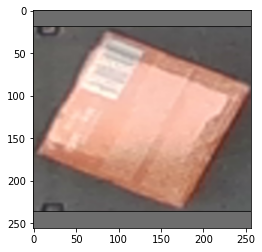

In [5]:
train_df = load_data('TRAIN')
loader = LoadData('TRAIN')
plt.imshow(loader[0][0].astype('int64'))

In [6]:
model_b7 = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling='max',
    classes=1000,
    classifier_activation="softmax")

In [7]:
embb7 = np.zeros((len(train_df), 2560))
for i in range(len(train_df)):
    embb7[i] = model_b7(loader[i])[0]

In [8]:
train_df['y'].unique()

array([ 8,  9,  1, 11,  4, 13, 10,  2,  6, 12,  5,  3])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 144 samples in 0.000s...
[t-SNE] Computed neighbors for 144 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 144 / 144
[t-SNE] Mean sigma: 25.140057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.283920
[t-SNE] KL divergence after 1000 iterations: 0.310826


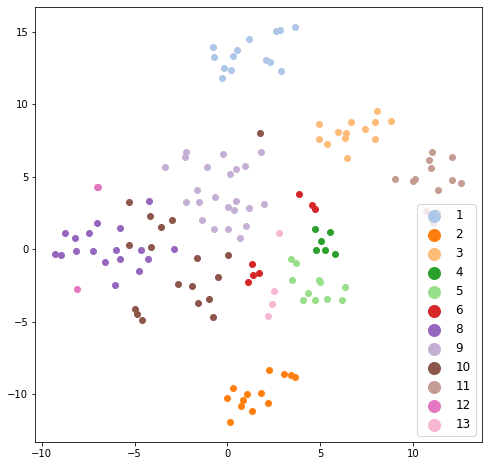

In [9]:
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(embb7)
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 28
for lab in range(1, num_categories+2):
    if lab not in train_df['y'].unique():
        pass
    else:
        indices = np.asarray(train_df['y'])==lab ########## Przy uruchomieniu zrobić zamiast df train_df lub val_df
        ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=1)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [10]:
val_df = load_data('VAL')
val_gen = LoadData('VAL')

In [11]:
results = []
for i in range(len(val_df)):
    if(i>0 and i%100==0):
        print(float(i)/len(val_df))
    if not val_df.iloc[i]['occ']:
        results.append(model_b7(val_gen[i])[0])
    else:
        results.append(np.NaN)

0.030003000300030003
0.060006000600060005
0.09000900090009001
0.12001200120012001
0.15001500150015
0.18001800180018002
0.21002100210021002
0.24002400240024002
0.27002700270027
0.3000300030003
0.33003300330033003
0.36003600360036003
0.39003900390039004
0.42004200420042004
0.45004500450045004
0.48004800480048004
0.51005100510051
0.54005400540054
0.57005700570057
0.6000600060006
0.6300630063006301
0.6600660066006601
0.6900690069006901
0.7200720072007201
0.7500750075007501
0.7800780078007801
0.8100810081008101
0.8400840084008401
0.8700870087008701
0.9000900090009001
0.9300930093009301
0.9600960096009601
0.9900990099009901


In [12]:
from scipy.spatial import distance
import numpy as np

MAX_CLASS = 14 #maksymalne id klasy


def compute_distances(x, embedding, method=distance.cosine):
    distances = np.zeros((embedding.shape[0]))
    for i in range(embedding.shape[0]):
        distances[i] = method(embedding[i], x)
    return distances

In [13]:
distances=[]

for i in range(len(results)):
    if results[i] is not np.NaN:
        distances.append(compute_distances(results[i], embb7))
    else:
        distances.append(np.NaN)

distances_df = pd.DataFrame(columns=range(144))

for i in range(len(distances)):
    if distances[i] is not np.NaN:
        a = pd.DataFrame(distances[i]).T
        distances_df = distances_df.append(a, ignore_index=True)
    else:
        distances_df = distances_df.append(pd.DataFrame([np.NaN]*144).T)

distances_df.dropna(how='any')

distances_df.dropna(how='any').to_csv('distances_df')

In [14]:
def classify(distances, classes):
    '''
    same lengths
    distances - np.array
    classes - np.array
    returns: class
    '''
    weights = {cls: [] for cls in classes}
    for i in range(len(distances)):
        weights[classes[i]].append(distances[i])

    m = max(sum(list(map(lambda x: pow(x, -1), scores)))/len(scores) for scores in weights.values())
    for cls in weights.keys():
        lm = sum(list(map(lambda x: pow(x, -1), weights[cls])))/len(weights[cls])
        if lm == m:
            return cls


'''
distances = [0.2, 0.2, 0.5, 0.8, 0.7, 0.7, 0.6, 0.5, 0.9, 0.6, 0.4, 0.3, 0.05]
classes =   ['A', 'B', 'B', 'C', 'A', 'A', 'C', 'C', 'C', 'B', 'B', 'B', 'C']
print('max: ', classify(distances, classes))
'''

"\ndistances = [0.2, 0.2, 0.5, 0.8, 0.7, 0.7, 0.6, 0.5, 0.9, 0.6, 0.4, 0.3, 0.05]\nclasses =   ['A', 'B', 'B', 'C', 'A', 'A', 'C', 'C', 'C', 'B', 'B', 'B', 'C']\nprint('max: ', classify(distances, classes))\n"

In [15]:
predictions = []


for i in range(len(distances)):
    if distances[i] is not np.NaN:
        predictions.append(classify(distances[i], train_df['y']))
    else:
        predictions.append(np.NaN)

In [16]:
val_df

,bbox,y,im_id,occ
0,"[282, 253, 59, 169]",None,20220221-212932.557424-scout.png,False
1,"[347, 229, 93, 69]",None,20220221-212932.557424-scout.png,False
2,"[340, 265, 30, 73]",None,20220221-212932.557424-scout.png,False
3,"[344, 203, 98, 30]",None,20220221-212932.557424-scout.png,False
4,"[381, 241, 106, 162]",None,20220221-212925.053507-scout.png,True
...,...,...,...,...
3328,"[387, 308, 62, 75]",None,20220221-203752.104636-scout.png,True
3329,"[420, 409, 37, 23]",None,20220221-203752.104636-scout.png,True
3330,"[245, 177, 46, 105]",None,20220221-203752.104636-scout.png,True
3331,"[422, 316, 79, 66]",None,20220221-203752.104636-scout.png,True


In [17]:
results_df = pd.DataFrame()
results_df['preds'] = predictions
results_df['y'] = val_df['y']

In [18]:
results_df.dropna(how='all')

,preds,y
0,2.0,None
1,11.0,None
2,8.0,None
3,11.0,None
8,2.0,None
...,...,...
3296,11.0,None
3297,3.0,None
3299,4.0,None
3317,11.0,None


In [19]:
json_path = '../../data/images_part1_test_public_copy.json'

with open(json_path, 'r+') as f:
    data = json.load(f)
    for i in range(len(results_df)):
        if results_df.iloc[i]['preds'] == results_df.iloc[i]['preds']:
            data['annotations'][i]['category_id'] = results_df.iloc[i]['preds']
        else:
            data['annotations'][i]['category_id'] = None
    f.seek(0)        # <--- should reset file position to the beginning.
    json.dump(data, f, indent=4)
    f.truncate()     # remove remaining part

off_res

off_res = off_res.drop(off_res.loc[off_res['y']==7].index)
off_res = off_res.drop(off_res.loc[off_res['y']>13].index)

(off_res['preds'] == off_res['y']).sum()/(len(off_res))

off_res

plt.imshow(val_gen[10][0].astype('int64'))

labs = train_df['y'].unique()
labs.sort()
labs

off_res.loc[off_res['y'] == 6]

off_res.loc[off_res['preds']!=off_res['y']].head(10)

deps = np.zeros((14,14))

for i in range(len(off_res)):
    deps[int(off_res.iloc[i]['preds']), int(off_res.iloc[i]['y'])] += 1

plt.imshow(deps, cmap='hot')

bad_class4 = embb7[train_df.loc[train_df['y']==4].index]

import tensorflow as tf
from tensorflow import keras
import numpy as np
from scipy.spatial import distance


def myLossFunction(sample):
    distances = []
    bad_class = bad_class4
    for bad_samp in bad_class:
        dist = distance.cosine(sample, bad_samp)
        distances.append(dist)

    return 1/np.mean(distances)

myLossFunctionVec = np.vectorize(myLossFunction)

class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        sample_weight = None
        x = data

        with tf.GradientTape() as tape:
            # y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = myLossFunctionVec(x)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct and compile an instance of CustomModel
model = CustomModel(model_b7)
model.compile(optimizer="adam")